In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd
import pathlib

In [2]:
import sys
sys.path.append('..')
from scripts.audio import audio_array_to_wav_file
from scripts.ipa import timit2ipa

In [ ]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()
print(timit_files)

In [ ]:
# print PHONCODE.DOC 
timit_phoncode = timit.open('PHONCODE.DOC')
for line in timit_phoncode:
    print(line.decode('utf-8').strip())

In [ ]:
# print PROMPTS.TXT
timit_prompts = timit.open('PROMPTS.TXT')
for line in timit_prompts:
    print(line.decode('utf-8').strip())

In [ ]:
# print README.DOC
timit_readme = timit.open('README.DOC')
for line in timit_readme:
    print(line.decode('utf-8').strip())

In [ ]:
# print SPKRINFO.TXT
timit_spkrinfo = timit.open('SPKRINFO.TXT')
for line in timit_spkrinfo:
    print(line.decode('utf-8').strip())

In [24]:
REGIONS = ['New England', 'Northern', 'North Midland', 'South Midland', 'Southern', 'New York City', 'Western', 'Army Brat (moved around)']
records = []
for line in timit.open('SPKRINFO.TXT'):
    line = line.decode('utf-8').strip()
    if line == "" or line.startswith(';'):
        continue
    line = line.split()
    if len(line) < 10:
        line += [""] * (10 - len(line))
    records.append({
        "speaker_initials": line[0],
        "sex": line[1],
        "dialect_region": REGIONS[int(line[2]) - 1],
        "use": "Train" if line[3] == "TRN" else "Test",
        "recording_date": line[4],
        "birth_date": line[5],
        "height": line[6],
        "race": line[7],
        "education_level": line[8],
        "comments": line[9]
    })
speaker_info_df = pd.DataFrame(records)
speaker_info_df.head()

,speaker_initials,sex,dialect_region,use,recording_date,birth_date,height,race,education_level,comments
0,ABC0,M,New York City,Train,03/03/86,06/17/60,"5'11""",WHT,BS,
1,ABW0,M,Northern,Test,04/21/86,05/26/59,"5'9""",WHT,BS,
2,ADC0,M,North Midland,Train,02/25/86,04/27/54,"5'9""",WHT,HS,
3,ADD0,M,Western,Train,01/28/86,03/23/58,"6'2""",WHT,BS,
4,ADG0,F,South Midland,Test,02/12/86,04/11/59,"5'4""",WHT,MS,


In [ ]:
# print SPKRSENT.TXT
timit_spkrsent = timit.open('SPKRSENT.TXT')
for line in timit_spkrsent:
    print(line.decode('utf-8').strip())

In [ ]:
# print TESTSET.DOC
timit_testset = timit.open('TESTSET.DOC')
for line in timit_testset:
    print(line.decode('utf-8').strip())

In [ ]:
# print TIMITDIC.DOC
timit_timitdic = timit.open('TIMITDIC.DOC')
for line in timit_timitdic:
    print(line.decode('utf-8').strip())

In [ ]:
# print TIMITDIC.TXT
timit_timitdic = timit.open('TIMITDIC.TXT')
for line in timit_timitdic:
    print(line.decode('utf-8').strip())

In [ ]:
# list the file extensions for each data point
set(map(lambda x: x.split('.')[1], filter(lambda x: x.startswith('data/TRAIN'), timit_files)))

In [ ]:
training_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TRAIN'), timit_files))))
print(training_files)

In [ ]:
test_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TEST'), timit_files))))
print(test_files)

In [16]:
def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            timestamped_phonemes.append((timit2ipa(phoneme), int(start) / 16_000, int(end) / 16_000))
    with timit.open(filename + '.TXT') as txt_file:
        transcription = txt_file.read().decode('utf-8').strip()
        # first two numbers are the start and end times
        transcription_start, transcription_end, *words = transcription.split()
        transcription = ' '.join(words)
    with timit.open(filename + '.WRD') as wrd_file:
        timestamped_words = []
        for line in wrd_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, word = line.split()
            timestamped_words.append((word, int(start) / 16_000, int(end) / 16_000))
    path_segments = pathlib.Path(filename).parts
    speaker_initials = path_segments[-2][1:]
    return {'speaker_initials': speaker_initials, 'timestamped_phonemes': timestamped_phonemes, 'transcription': transcription, 'transcription_start': int(transcription_start) / 16_000, 'transcription_end': int(transcription_end) / 16_000, 'timestamped_words': timestamped_words, 'wav_filename': filename + '.WAV'}

In [17]:
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)

In [ ]:
parsed_0 = timit_file_to_dict(training_files[0])
print(parsed_0)

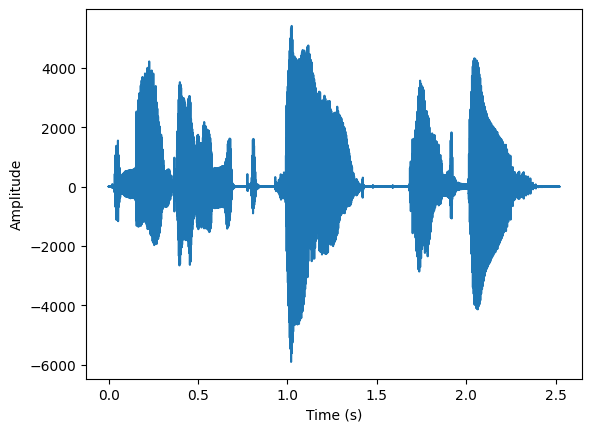

In [ ]:
arr_0 = zipped_wav_to_array(parsed_0['wav_filename'])
start = parsed_0['timestamped_phonemes'][0][2]
arr_0 = arr_0[int(start * 16000):]
audio_array_to_wav_file(arr_0, '../data/audio-tests/TIMIT_sample_0.wav')
time = np.arange(0, len(arr_0)) / 16000
plt.plot(time, arr_0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [20]:
phonemic_transcription = "".join(map(lambda x: x[0], parsed_0['timestamped_phonemes']))
print(phonemic_transcription)

ðɨmæŋɡoʊɛnðɨpəpaɪʌɑɹɪɾ̃ɨboʊl


In [21]:
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['phonemes'] = [phoneme for phoneme, _, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        parsed['words'] = [word for word, _, _ in parsed['timestamped_words']]
        parsed['word_starts'] = [start for _, start, _ in parsed['timestamped_words']]
        parsed['word_ends'] = [end for _, _, end in parsed['timestamped_words']]
        del parsed['timestamped_words']
        records.append(parsed)
    df = pd.DataFrame(records)
    return df.merge(speaker_info_df, on='speaker_initials', how='left')

In [ ]:
train_df = files_to_df(training_files)
train_df.head()

In [ ]:
train_ds = Dataset.from_pandas(train_df)
print(train_ds[0])

In [ ]:
test_df = files_to_df(test_files)
test_df.head()

In [ ]:
test_ds = Dataset.from_pandas(test_df)
print(test_ds[0])

In [38]:
# Export some samples
import os
SAVE_DIR = '../.data/TIMIT-Samples'
os.makedirs(SAVE_DIR, exist_ok=True)
pd.set_option('display.max_colwidth', None)
for i in range(20):
    row = test_df.iloc[i]
    audio = np.array(row['audio'])
    # start = row['phoneme_ends'][0]
    # audio = audio[int(start * 16000):]
    audio_array_to_wav_file(audio, f'{SAVE_DIR}/test_{i}.wav')
    with open(f'{SAVE_DIR}/test_{i}.txt', 'w') as f:
        f.write(row[[col for col in test_df.columns if col != 'audio']].to_string())
    